<a href="https://colab.research.google.com/github/Owaiskhan9654/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/blob/master/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feb 2023 Updated with Google Colab Commands**

In [ ]:
!pip install --upgrade --no-cache-dir gdown


import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


#Kernal will Restart here automatically

In [1]:
!git clone https://github.com/Owaiskhan9654/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow

%cd /content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow

Cloning into 'Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow'...
remote: Enumerating objects: 88, done.
remote: Total 88 (delta 0), reused 0 (delta 0), pack-reused 88
Unpacking objects: 100% (88/88), 3.32 MiB | 2.29 MiB/s, done.
/content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow


In [2]:
import gdown
url = 'https://docs.google.com/uc?export=download&id=1ObrV9pbH_-LBGbIodWgB6W4dtQloTTH6'
output = 'Data.tar.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://docs.google.com/uc?export=download&id=1ObrV9pbH_-LBGbIodWgB6W4dtQloTTH6
To: /content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/Data.tar.gz
100%|██████████| 259M/259M [00:01<00:00, 171MB/s]


'Data.tar.gz'

In [3]:
%%capture

!mkdir Data
!tar -xvf  '/content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/Data.tar.gz' -C '/content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/Data'


In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt



image_path = 'Data/images/'
gt_path = 'Data/ground_truth/'
train_image_paths = []
train_gt_paths = []


for new_file in tqdm.tqdm(os.listdir(gt_path)):
    
    name_split = new_file.split('.')
    image_name = name_split[0][3:]
    image_name = image_name + '.jpg'
    
    if 'gt' in new_file:
        image_name = name_split[0][3:]
        image_name = image_name + '.jpg'
    
    path_img = os.path.join(image_path , image_name)
    train_image_paths.append(path_img)
    train_gt_paths.append(os.path.join(gt_path , new_file))



X_final = []
Y_final = []
grid_h = 16
grid_w = 16
img_w = 512
img_h = 512



for z in tqdm.tqdm(range(len(train_image_paths))):
    
    new_file = train_image_paths[z]
    #print(new_file)
    x = cv2.imread(train_image_paths[z])
    x_sl = 512/x.shape[1]
    y_sl = 512/x.shape[0]
    
    img = cv2.resize(x,(512,512))
    
    
    X_final.append(img)
    
    #plt.imshow(cv2.imread(new_file))
    #plt.show()
    
    i = " "
    
    if 'img' in new_file:
        i = ", "
    
    Y = np.zeros((grid_h,grid_w,1,5))
    
    file = train_gt_paths[z]
    name = open(file , 'r')
    data = name.read()
    data = data.split("\n")
    data = data[:-1]
    
    
    for li in data:
        temp_list = []
        file_data = li.split(i)
        strr = file_data[4]
        bb = file_data[:4]
        
        xmin = int(bb[0])*x_sl
        xmax = int(bb[2])*x_sl
        ymin = int(bb[1])*y_sl
        ymax = int(bb[3])*y_sl
        
        #te = cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)) , color = (0,255,0))
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h
        
        x = ((xmax + xmin)/2)/img_w
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    #plt.imshow(te)
    #plt.show()
    
    Y_final.append(Y)
    




X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5

np.save('Data/X.npy',X)
np.save('Data/Y.npy',Y)

100%|██████████| 461/461 [00:17<00:00, 25.76it/s]


In [5]:
from tensorflow.keras import backend as K
import keras
import cv2
from Utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import os

In [6]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [7]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('Data/X.npy')
Y = np.load('Data/Y.npy')

In [8]:
print(X.shape , Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [9]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X = []
Y = []

In [10]:
#define model
# input : 512,512,3
# output : 16,16,1,5



def save_model(model):
    model_json = model.to_json()
    with open("model/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

        
        
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    

    
    
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)

    
    inp = Input(input_shape)

    model = MobileNetV2(
        input_tensor=inp, include_top=False, weights='imagenet')
    last_layer = model.output
    conv = Conv2D(512, (3, 3), activation=tf.nn.leaky_relu,
                  padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    conv = Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    conv = Conv2D(5, (3, 3), activation=tf.nn.leaky_relu, padding='same')(lr)
    final = Reshape((grid_h, grid_w, classes, info))(conv)

    model = Model(inp, final)
    return model



In [11]:
#define utils

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# opt = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)

#checkpoint
checkpoint = ModelCheckpoint('model/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [13]:
#load and save model
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

save_model(model)


9406464/9406464 [==============================] - 0s 0us/step


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [14]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [15]:
hist = model.fit(X_train ,Y_train ,epochs= 50 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 424.8813 - accuracy: 0.0790
Epoch 1: val_loss improved from inf to 229.00417, saving model to model/text_detect.h5
87/87 [==============================] - 31s 199ms/step - loss: 424.8813 - accuracy: 0.0790 - val_loss: 229.0042 - val_accuracy: 0.0531
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 245.2811 - accuracy: 0.0514
Epoch 2: val_loss improved from 229.00417 to 192.18684, saving model to model/text_detect.h5
87/87 [==============================] - 16s 181ms/step - loss: 245.2811 - accuracy: 0.0514 - val_loss: 192.1868 - val_accuracy: 0.1070
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 203.0735 - accuracy: 0.0398
Epoch 3: val_loss improved from 192.18684 to 164.61330, saving model to model/text_detect.h5
87/87 [==============================] - 15s 177ms/step - loss: 203.0735 - accuracy: 0.0398 - val_loss: 164.6133 - val_accuracy: 0.1533
Epoch 4/50
87/87 [=============

In [16]:
model.save_weights('model/text_detect.h5')

In [21]:
url = 'https://docs.google.com/uc?export=download&id=1OwrEu6SeaNM3l_clLN9F40W-tMpRfz97'
output = 'text_detect.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://docs.google.com/uc?export=download&id=1OwrEu6SeaNM3l_clLN9F40W-tMpRfz97
To: /content/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/text_detect.h5
100%|██████████| 35.4M/35.4M [00:00<00:00, 38.6MB/s]


'text_detect.h5'

In [22]:
model = load_model('model/text_detect_model.json')
model.load_weights('text_detect.h5')

In [23]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)
    
    

1/1 [==============================] - 1s 637ms/step


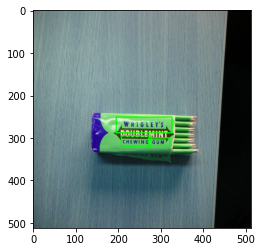

1/1 [==============================] - 0s 24ms/step


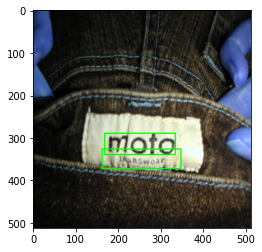

1/1 [==============================] - 0s 28ms/step


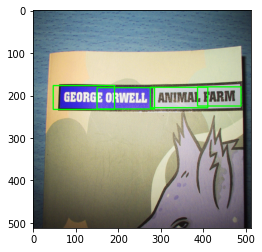

1/1 [==============================] - 0s 28ms/step


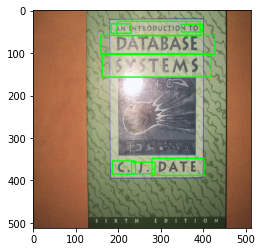

1/1 [==============================] - 0s 22ms/step


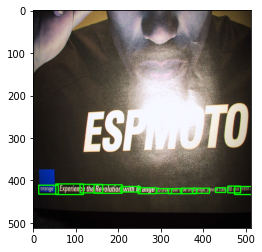

In [24]:
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    
    predict_func(model , X_val[i:i+1] , 0.25, i)
    

1/1 [==============================] - 0s 21ms/step


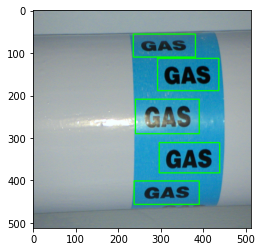

In [25]:
for i in os.listdir('Test'):
    img = cv2.imread(os.path.join('Test',i))
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model , np.expand_dims(img,axis= 0) , 0.25 , 'sample')

### THE END